In [1]:
import numpy as np
import requests
import os
from numpy.linalg import eigh
import matplotlib.pyplot as plt
import mdtraj as md
import nglview as nv
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib as mpl

# Working with the Kirchoff matrix of the Gaussian Network Model

## Downloading any PDB file

Let's first of all store the PDB id we want to download and the path where the file needs to be located:

In [2]:
pdb_id = '1HIV'
download_path = "./"

And now let's define an auxiliary function to download pdb files to be stored locally in our machine.

In [3]:
def fetch_pdb(pdb_id, download_path="./"):
        url = 'http://files.rcsb.org/download/{}.pdb'.format(pdb_id)
        try:
            res = requests.get(url, allow_redirects=True)
        except:
            print("Could not fetch pdb from {}".format(url))
            return 
        
        file_path = os.path.join(download_path, pdb_id + ".pdb")
        with open(file_path, "wb") as f:
            f.write(res.content)
        print(f"The {pdb_id} file was downloaded succesfully!")

Time to try it!

In [4]:
fetch_pdb(pdb_id, download_path=download_path)

The 1HIV file was downloaded succesfully!


## Parsing the positions of the CA atoms

We are going take an approach not very short and efficiente to obtain the coordinates of the CA atoms. But let's do it this way just once:

In [56]:
file_path = os.path.join(download_path, pdb_id + ".pdb")

CA_coordinates = []

with open(file_path) as fff:
    for line in fff.readlines():
        if (line.startswith('ATOM  ') or line.startswith('HETATM')):
            if line.split()[2]=='CA' and line.split()[3]!='1ZK' :

                x, y, z = line.split()[6:9]
                CA_coordinates.append([float(x), float(y), float(z)])

Ok, `CA_coordinates` is a list of lists... let's convert it to a numpy array:

In [58]:
CA_coordinates = np.array(CA_coordinates)

In [59]:
#Alpha carbon number
len(CA_coordinates)

198

## Defining the Kirchhoff matrix

In [60]:
def kirchhoff_matrix(CA, threshold):
    num_CAs = CA.shape[0]
    matrix = np.zeros((num_CAs, num_CAs), dtype=int)
    for ii in range(num_CAs):
        for jj in range(ii):
            rij=CA[ii]-CA[jj]
            distance=np.sqrt(np.dot(rij,rij))
            if distance<threshold:
                matrix[ii,jj] = -1
                matrix[jj,ii] = -1
                matrix[ii,ii] += 1
                matrix[jj,jj] += 1
    return matrix

In [61]:
K_matrix = kirchhoff_matrix(CA_coordinates, 9.0)
K_matrix

array([[ 5, -1, -1, ..., -1, -1, -1],
       [-1,  7, -1, ..., -1, -1, -1],
       [-1, -1, 10, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., 16, -1, -1],
       [-1, -1, -1, ..., -1, 12, -1],
       [-1, -1, -1, ..., -1, -1, 10]])

## Diagonalizing from its eigenvalues

In [62]:
evals, evects = eigh(K_matrix)

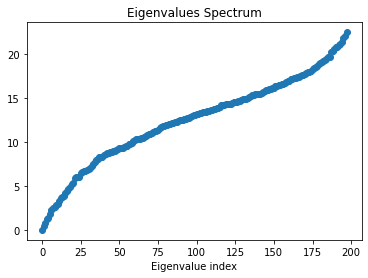

In [63]:
num_modes = evals.shape[0]

plt.scatter(range(num_modes), evals)
plt.title('Eigenvalues Spectrum')
plt.xlabel('Eigenvalue index')
plt.show()

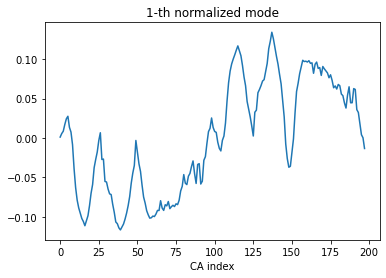

In [64]:
mode_index = 1
plt.plot(range(num_modes), evects[:,mode_index])
plt.title(f'{mode_index}-th normalized mode')
plt.xlabel('CA index')
plt.show()

## Obtaining $\Gamma^{-1}$ from the N-1 non-zero eigenvalues


In [65]:
#Removing 0 eigenvalue and corresponding eigenvector
evals_new=np.delete(evals,0)
evects_new=np.delete(evects,0,1)

In [66]:
#Defining the diagonalized matrix of eigenvalues
D=np.diag(evals_new)

In [67]:
#Defining invertible Kirchhoff matrix
K_matrix_inv=np.matmul(evects_new, np.matmul(np.linalg.inv(D),np.transpose(evects_new)))

In [68]:
#Defining the B factors
kb=1.38064852e-23 #Boltzmann constant
T=100 #Experimental temperature
f=6e-22 #Arbitrary force constant
B_Theory=[8*np.pi**2*kb*T/f*K_matrix_inv[ii][ii] for ii in range(len(K_matrix_inv))]

In [69]:
#Reading B factors from PDB
B_exp=[]
with open(file_path) as fff:
    for line in fff.readlines():
        if (line.startswith('ATOM  ') or line.startswith('HETATM')):
            if line.split()[2]=='CA' and line.split()[3]!='1ZK' :
            
                Bi = line.split()[10]
                B_exp.append(float(Bi))

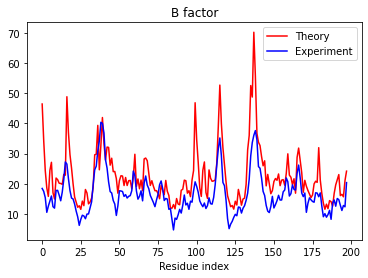

In [70]:
plt.plot(range(num_modes), B_Theory,c='red',label = 'Theory')
plt.plot(range(num_modes), B_exp,c='blue',label='Experiment')
plt.title('B factor')
plt.xlabel('Residue index')
plt.legend()
plt.show()

## Calculating correlation matrix from Kirchhoff Matrix

In [71]:
Corr_Matrix=3*kb*T/f*K_matrix_inv

In [72]:
Corr_Matrix.max()

2.6655855541930764

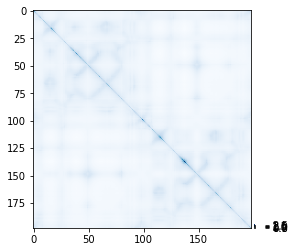

In [74]:
ax = plt.subplot()
im = ax.imshow(Corr_Matrix,cmap='Blues')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.xlim([0,198])
plt.ylim([0,198])
plt.show()

## Cartoon representation of B factors [Iván]

In [ ]:
traj = md.load(file_path)

In [ ]:
atoms_in_protein = traj.topology.select('chainid 0 1')

In [ ]:
traj_protein = traj.atom_slice(atoms_in_protein)

In [ ]:
#Red color palette
pal = sns.color_palette('Reds', 7)
reds=pal.as_hex()

In [ ]:
interval=np.linspace(11,71,8)#Dividing B factors value in 8 intervals
scheme=[]
for ii in range(1,100):
    for jj in range(7):
        if interval[jj] <=B_Theory[ii] < interval[jj+1]:
            scheme.append(['{}'.format(reds[jj]),'{}'.format(ii)])#Adding color according to B factor value


In [ ]:
#Creating color scheme
colors=nv.color._ColorScheme(scheme,label=True)

In [ ]:
view=nv.show_mdtraj(traj_protein)
view.clear_representations()
view.add_cartoon(color=colors)
view

## Cartoon representation of B factors [Diego]

Cargamos cuatro objetos que vamos a usar...

In [75]:
# Cargo cuatro elementos que vamos a usar

from matplotlib.colors import Normalize, to_hex
from nglview.color import _ColorScheme
from matplotlib import cm

Y creamos un objeto nativo "trajectory" de mdtraj con el dímero.

In [76]:
traj = md.load(file_path)
atoms_in_protein = traj.topology.select('chainid 0 1')
traj_protein = traj.atom_slice(atoms_in_protein)

In [78]:
residue_labels = {}
chain_index_to_id = {0:'A', 1:'B'}

for residue in traj_protein.topology.residues:
    label = str(residue.resSeq) + ':' + str(chain_index_to_id[residue.chain.index])
    residue_labels[residue.index]=label

En este punto, vamos crear una variable auxiliar llamada "values_per_residue". De esta manera, si quieres visualizar por ejemplo el primero modo normal... los valores experimentales o teóricos de los beta factors... o los valores de auto-correlación (la diagonal de la matriz de correlación), sólo tienes que darle nuevo contenido a dicha variable.

In [79]:
values_per_residue = B_Theory

Ahora, con ayuda de los matplotlib, vamos a mapear los valores almacenados en "values_per_residue" según una escala de color que vamos a definir. Y vamos a guardar dichos colores en código hexadecimal.

Podríamos hacerlo a mano, pero para ser más rápidos, vamos a servirnos de los colormaps de Matplotlib:

In [80]:
cmap = cm.get_cmap('Reds') # Elegimos el mapa de rojos

Y hacemos uso de la clase 'Normalize' de matplotlib para reescalar linealmente nuestros valores entre un cierto valor máximo y otro cierto valor mínimo definidos por nosotros. También podríamos hacerlo a mano... pero ya que está:

In [81]:
norm = Normalize(vmin=0.0, vmax=np.max(values_per_residue))

Ya podemos calcular los colores por residuo:

In [82]:
colors_per_residue = []

for value in values_per_residue:
    colors_per_residue.append(to_hex(cmap(norm(value))))

In [83]:
print(colors_per_residue)

['#e43027', '#fb6d4d', '#fc9b7c', '#fcb69b', '#fcc3ab', '#fc9b7c', '#fc8f6f', '#fcbda4', '#fdc6b0', '#fca78b', '#fca98c', '#fcaf93', '#fcaf93', '#fcb095', '#fca183', '#fca285', '#da2723', '#f96044', '#fc8262', '#fc9777', '#fcaf93', '#fcc3ab', '#fdcbb6', '#fdd2bf', '#fdd0bc', '#fdd4c2', '#fdc9b3', '#fdd0bc', '#fcb89e', '#fcbea5', '#fdcdb9', '#fdcab5', '#fdc5ae', '#fcb69b', '#fc8262', '#fc8262', '#f5533b', '#fc9b7c', '#fb7555', '#f14432', '#fb7252', '#fc8b6b', '#fb7757', '#fb7858', '#fc9373', '#fc8969', '#fc9d7f', '#fc9d7f', '#fca78b', '#fcbea5', '#fcab8f', '#fca486', '#fca486', '#fcb398', '#fca689', '#fcb398', '#fcab8f', '#fcaa8d', '#fcb89e', '#fca588', '#fc8262', '#fcb499', '#fca98c', '#fcb79c', '#fcaa8d', '#fcbba1', '#fc8969', '#fc8767', '#fc8d6d', '#fca082', '#fcb296', '#fcab8f', '#fcb398', '#fcbba1', '#fcbba1', '#fcbea5', '#fdc5ae', '#fcb296', '#fcb99f', '#fcc1a8', '#fcaa8d', '#fcbba1', '#fcc2aa', '#fdd3c1', '#fdd3c1', '#fdcebb', '#fdd4c2', '#fdc5ae', '#fdcdb9', '#fdcebb', '#fcb99f'

Ahora necesitamos crear el objecto '_ColorScheme' de nglview... indicando qué color corresponde a qué índice de residuo:

In [84]:
auxiliar_list = [[ii, residue_labels[jj]] for ii,jj in zip(colors_per_residue, range(len(colors_per_residue)))]

In [85]:
auxiliar_list

[['#e43027', '1:A'],
 ['#fb6d4d', '2:A'],
 ['#fc9b7c', '3:A'],
 ['#fcb69b', '4:A'],
 ['#fcc3ab', '5:A'],
 ['#fc9b7c', '6:A'],
 ['#fc8f6f', '7:A'],
 ['#fcbda4', '8:A'],
 ['#fdc6b0', '9:A'],
 ['#fca78b', '10:A'],
 ['#fca98c', '11:A'],
 ['#fcaf93', '12:A'],
 ['#fcaf93', '13:A'],
 ['#fcb095', '14:A'],
 ['#fca183', '15:A'],
 ['#fca285', '16:A'],
 ['#da2723', '17:A'],
 ['#f96044', '18:A'],
 ['#fc8262', '19:A'],
 ['#fc9777', '20:A'],
 ['#fcaf93', '21:A'],
 ['#fcc3ab', '22:A'],
 ['#fdcbb6', '23:A'],
 ['#fdd2bf', '24:A'],
 ['#fdd0bc', '25:A'],
 ['#fdd4c2', '26:A'],
 ['#fdc9b3', '27:A'],
 ['#fdd0bc', '28:A'],
 ['#fcb89e', '29:A'],
 ['#fcbea5', '30:A'],
 ['#fdcdb9', '31:A'],
 ['#fdcab5', '32:A'],
 ['#fdc5ae', '33:A'],
 ['#fcb69b', '34:A'],
 ['#fc8262', '35:A'],
 ['#fc8262', '36:A'],
 ['#f5533b', '37:A'],
 ['#fc9b7c', '38:A'],
 ['#fb7555', '39:A'],
 ['#f14432', '40:A'],
 ['#fb7252', '41:A'],
 ['#fc8b6b', '42:A'],
 ['#fb7757', '43:A'],
 ['#fb7858', '44:A'],
 ['#fc9373', '45:A'],
 ['#fc8969', '46:A'

In [86]:
scheme = _ColorScheme(auxiliar_list, label='user')

In [87]:
print(scheme.data)

{'data': [['#e43027', '1:A'], ['#fb6d4d', '2:A'], ['#fc9b7c', '3:A'], ['#fcb69b', '4:A'], ['#fcc3ab', '5:A'], ['#fc9b7c', '6:A'], ['#fc8f6f', '7:A'], ['#fcbda4', '8:A'], ['#fdc6b0', '9:A'], ['#fca78b', '10:A'], ['#fca98c', '11:A'], ['#fcaf93', '12:A'], ['#fcaf93', '13:A'], ['#fcb095', '14:A'], ['#fca183', '15:A'], ['#fca285', '16:A'], ['#da2723', '17:A'], ['#f96044', '18:A'], ['#fc8262', '19:A'], ['#fc9777', '20:A'], ['#fcaf93', '21:A'], ['#fcc3ab', '22:A'], ['#fdcbb6', '23:A'], ['#fdd2bf', '24:A'], ['#fdd0bc', '25:A'], ['#fdd4c2', '26:A'], ['#fdc9b3', '27:A'], ['#fdd0bc', '28:A'], ['#fcb89e', '29:A'], ['#fcbea5', '30:A'], ['#fdcdb9', '31:A'], ['#fdcab5', '32:A'], ['#fdc5ae', '33:A'], ['#fcb69b', '34:A'], ['#fc8262', '35:A'], ['#fc8262', '36:A'], ['#f5533b', '37:A'], ['#fc9b7c', '38:A'], ['#fb7555', '39:A'], ['#f14432', '40:A'], ['#fb7252', '41:A'], ['#fc8b6b', '42:A'], ['#fb7757', '43:A'], ['#fb7858', '44:A'], ['#fc9373', '45:A'], ['#fc8969', '46:A'], ['#fc9d7f', '47:A'], ['#fc9d7f', 

Ya lo tenemos!

In [88]:
view = nv.show_mdtraj(traj_protein)
view.clear()
view.add_cartoon(selection='all', color=scheme)
view

NGLWidget()